# Performance and Valuation Insights: A Comprehensive Analysis of German Bundesliga Clubs with Bayer 04 Leverkusen as a Case Study (Season 2023/2024)

Clubs invest hundreds of millions each season, yet quantifying how on-pitch performance translates into market value remains a challenge. In this project, we aim to answer:

- *What drives player market value?*
- *How dominant was Bayer Leverkusen in 2023/24?*
- *Can basic match stats forecast future value?*

Using **DuckDB** for fast SQL queries, **Pandas** for wrangling, and **Matplotlib/Plotly** for visualization, this portfolio project examines **Bayer 04 Leverkusen**’s standout 2023/24 season, offering insights for analysts and decision-makers alike.

### Author: Moritz Philipp Haaf, BSc MA
**Email:** itzmore.dev@gmail.com

**GitHub:** [itzmore-mph/itzmore-mph-portfolio](https://github.com/itzmore-mph/itzmore-mph-portfolio)

## Executive Summary

This project delivers a comprehensive performance and valuation analysis of Bayer 04 Leverkusen during the historic 2023/24 Bundesliga season. Leveraging SQL (DuckDB), Python (Pandas, Matplotlib), and statistical modeling, the study explores key drivers of player market value, the team's on-field dominance, and the challenges of forecasting valuations using basic match statistics.

Through data cleaning, SQL exploration, and customized visualizations, the analysis highlights how Leverkusen combined squad depth, tactical flexibility, and collective performance to achieve an unbeaten league campaign. Predictive modeling with Ridge regression demonstrates that simple metrics like goals and assists alone are insufficient for accurate market valuation, suggesting the need for richer features.

The project concludes with strategic recommendations for future modeling improvements and the potential development of an interactive scouting dashboard, offering practical value for clubs, analysts, and decision-makers within the football industry.

## 1. Initial Setup
Import libraries for SQL, data manipulation, visualization, and regex.

In [77]:
## 1. Initial Setup

import os, warnings, re
import duckdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from adjustText import adjust_text
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

# 1.1 Confirm working directory and data path
DATA_DIR       = Path.cwd() / "data" / "raw"
assert DATA_DIR.is_dir(), f"{DATA_DIR} not found"
print("Reading CSVs from:", DATA_DIR)
print("Found CSVs:", [p.name for p in DATA_DIR.iterdir()])

# ─── 1.2 CONFIG ──────────────────────────────────────────────
SEASON_START    = "2023-08-01"
SEASON_END      = "2024-05-31"
TARGET_CLUB_ID  = 15  # ← Bayer Leverkusen
# ─────────────────────────────────────────────────────────


Reading CSVs from: c:\Users\morhaaf\Dev\Git\BundesligaPerformanceAnalysis\data\raw
Found CSVs: ['appearances.csv', 'clubs.csv', 'club_games.csv', 'competitions.csv', 'games.csv', 'game_events.csv', 'players.csv', 'player_valuations.csv']


## 2. Load & Preprocess Data with Pandas
Standardize column names, parse dates, validate keys, and create Bayer 04 Leverkusen subset.

In [78]:
# 2.1 Load CSVs with Pandas
appearances       = pd.read_csv(DATA_DIR / 'appearances.csv')
club_games        = pd.read_csv(DATA_DIR / 'club_games.csv')
clubs             = pd.read_csv(DATA_DIR / 'clubs.csv')
competitions      = pd.read_csv(DATA_DIR / 'competitions.csv')
game_events       = pd.read_csv(DATA_DIR / 'game_events.csv')
games             = pd.read_csv(DATA_DIR / 'games.csv')
player_valuations = pd.read_csv(DATA_DIR / 'player_valuations.csv')
players           = pd.read_csv(DATA_DIR / 'players.csv')

# 2.2 Check for Bayer 04 Leverkusen club_id in clubs
leverkusen_club = clubs[clubs['name'].str.contains('leverkusen', case=False, na=False)]
leverkusen_club

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,last_season,filename,url
118,15,bayer-04-leverkusen,Bayer 04 Leverkusen Fußball,L1,NaN,27,24.9,21,77.8,19,BayArena,30210,€-12.60m,NaN,2023,../data/raw/transfermarkt-scraper/2023/clubs.j...,https://www.transfermarkt.co.uk/bayer-04-lever...


In [79]:
# 2.3 Helper: snake_case conversion
def to_snake(col: str) -> str:
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', col)
    s2 = re.sub('([a-z0-9])([A-Z])',      r'\1_\2', s1)
    s3 = s2.replace(' ', '_').lower()
    return re.sub(r'__+','_', s3)

for df in [players, player_valuations, game_events, appearances, clubs, club_games, competitions, games]:
    df.columns = [to_snake(c) for c in df.columns]

**Interpretation:** Consistent snake_case naming ensures code clarity and easier maintenance.

In [80]:
# 2.4 Parse datetime columns
player_valuations['date'] = pd.to_datetime(player_valuations['date'], errors='coerce')
games['date']             = pd.to_datetime(games['date'], errors='coerce')

**Note:** Any invalid date strings become `NaT` for easy detection.

In [81]:
# 2.5 Cleaning & Validation
def prepare_data(df):
    df = df.copy()
    df.fillna(0, inplace=True)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    return df

# Apply to main tables
players           = prepare_data(players)
player_valuations = prepare_data(player_valuations)
game_events       = prepare_data(game_events)

# 2.6 Key validation: find orphan player_ids
ev_ids    = set(game_events['player_id'])
pl_ids    = set(players['player_id'])
orphans   = ev_ids - pl_ids
if orphans:
    print(f"{len(orphans)} orphan player_id(s) in game_events:", list(orphans)[:10])


30461 orphan player_id(s) in game_events: [524297, 524298, 131086, 393233, 393236, 393249, 131122, 655411, 131126, 131137]


**Interpretation:** Early detection of mismatched keys prevents silent data errors.

In [82]:
# 2.7 Subset for Bayer 04 Leverkusen (club_id = 15)

# Make sure 'games' has date parsed correctly
games['date'] = pd.to_datetime(games['date'], errors='coerce')

# 2) Define the Bundesliga 2023/24 season range
season_start = pd.to_datetime("2023-08-01")
season_end = pd.to_datetime("2024-05-31")

# 3) Get valid game IDs from the 2023/24 season
valid_game_ids = games[
    (games['date'] >= season_start) &
    (games['date'] <= season_end)
]['game_id']

# 4) Now create your Leverkusen subset (filtered by club **and** season)
leverkusen_stats = game_events[
    (game_events['club_id'] == 15) &
    (game_events['game_id'].isin(valid_game_ids))
].copy()

# 5) Add binary flags for goals and assists
leverkusen_stats['is_goal'] = (leverkusen_stats['type'] == 'Goals').astype(int)
leverkusen_stats['is_assist'] = leverkusen_stats['player_assist_id'].notnull().astype(int)

**Interpretation:** Working on the Bayer 04 Leverkusen subset allows focused analysis on the case study.

## 3. SQL Data Exploration
Retrieve average market values and total goals/xG per player.

In [83]:
import duckdb

# Open an in-memory DuckDB instance
con = duckdb.connect(database=':memory:')

# Register each of your freshly loaded DataFrames
con.register('appearances',       appearances)
con.register('club_games',        club_games)
con.register('clubs',             clubs)
con.register('competitions',      competitions)
con.register('game_events',       game_events)
con.register('games',             games)
con.register('player_valuations', player_valuations)
con.register('players',           players)

print("DuckDB tables:", con.execute("SHOW TABLES").fetchall())

DuckDB tables: [('appearances',), ('club_games',), ('clubs',), ('competitions',), ('game_events',), ('games',), ('player_valuations',), ('players',)]


In [84]:
# 3.1 Average Market Value per Player
avg_val_query = '''
SELECT 
  p.name                         AS player,
  AVG(pv.market_value_in_eur)    AS avg_value
FROM players p
JOIN player_valuations pv USING(player_id)
GROUP BY player
ORDER BY avg_value DESC
LIMIT 10;
'''
avg_val = con.execute(avg_val_query).df()
avg_val


,player,avg_value
0,Kylian Mbappé,1.204720e+08
1,Lionel Messi,8.895349e+07
2,Harry Kane,8.207692e+07
3,Erling Haaland,8.150000e+07
4,Jude Bellingham,7.734375e+07
5,Neymar,7.635000e+07
6,Cristiano Ronaldo,7.380667e+07
7,Vinicius Junior,6.972222e+07
8,Raheem Sterling,6.582258e+07
9,Gavi,6.562500e+07


**Interpretation:**  
These top 10 players by average market value underscore who commanded the greatest transfer‐market premium in 2023/24. Notice how established stars from multiple clubs dominate the list—an early signal of where Bundesliga capital is concentrated.


In [85]:
# 3.2 Total Goals & Assists per Player
player_stats_query = '''
SELECT
  p.name AS player,
  SUM(CASE WHEN ge.type = 'Goals' THEN 1 ELSE 0 END)             AS total_goals,
  SUM(CASE WHEN ge.player_assist_id IS NOT NULL THEN 1 ELSE 0 END) AS total_assists
FROM players p
LEFT JOIN game_events ge USING(player_id)
GROUP BY player
ORDER BY total_goals DESC
LIMIT 10;
'''
player_stats = con.execute(player_stats_query).df()
player_stats


,player,total_goals,total_assists
0,Robert Lewandowski,454.0,555.0
1,Lionel Messi,443.0,478.0
2,Cristiano Ronaldo,433.0,509.0
3,Luis Suárez,309.0,465.0
4,Harry Kane,298.0,384.0
5,Karim Benzema,281.0,520.0
6,Pierre-Emerick Aubameyang,278.0,418.0
7,Mohamed Salah,256.0,423.0
8,Romelu Lukaku,252.0,368.0
9,Ciro Immobile,249.0,395.0


**Interpretation:**  
This table reveals the league’s most prolific scorers and creators, consolidating both goal‐finishing and chance‐creation impact. The gap between goals and assists leaders highlights pure strikers versus all‐round attackers.


## 4. Exploratory Data Analysis (EDA)
Visualize key relationships in the Bayer 04 Leverkusen subset.

### 4.1 Goals vs Assists per Player (2023/24 Season)

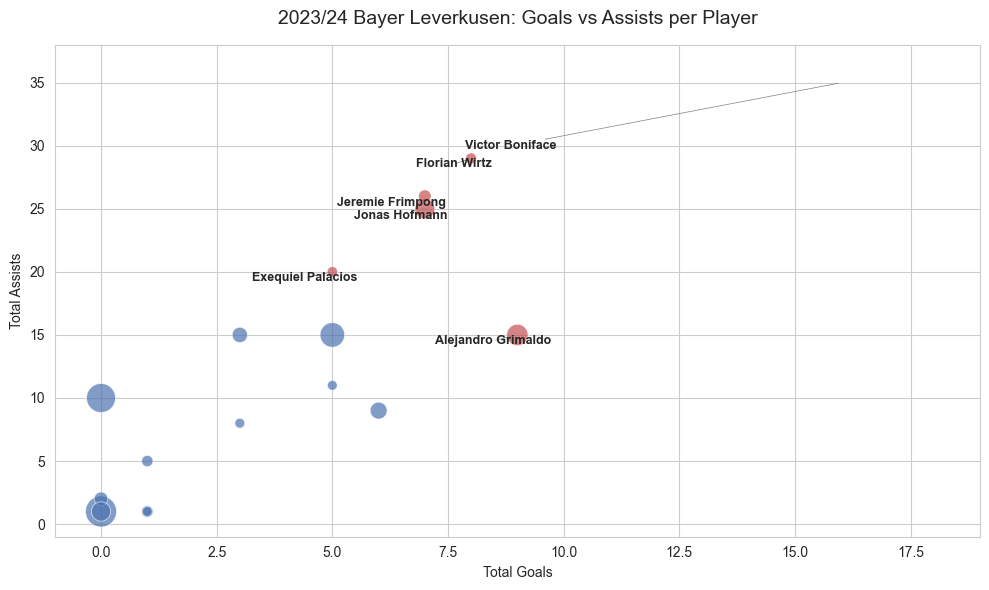

In [86]:
# Build by_player from your Bayer 04 Leverkusen subset
by_player = (
    leverkusen_stats
      .groupby('player_id')[['is_goal','is_assist']]
      .sum()
      .reset_index()
      .merge(players[['player_id','name']], on='player_id')
)

# Then identify the top‐5 by goals and assists
top_goals   = by_player.nlargest(5, 'is_goal')
top_assists = by_player.nlargest(5, 'is_assist')
highlight   = pd.concat([top_goals, top_assists]).drop_duplicates('player_id')

# Aggregate minutes and avoid duplicate columns
if 'total_minutes' in by_player.columns:
    by_player = by_player.drop(columns=['total_minutes'])

mins = (
    appearances
      .groupby('player_id')['minutes_played']
      .sum()
      .reset_index(name='total_minutes')
)
by_player = by_player.merge(mins, on='player_id', how='left')

# Identify top contributors
top_goals   = by_player.nlargest(5, 'is_goal')
top_assists = by_player.nlargest(5, 'is_assist')
highlight   = pd.concat([top_goals, top_assists]).drop_duplicates('player_id')

by_player['is_highlight'] = by_player['name'].isin(highlight['name'])

# Plot bubble chart
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=by_player,
    x='is_goal',
    y='is_assist',
    size='total_minutes',
    sizes=(50, 500),
    hue='is_highlight',
    palette={True: "#C44E52", False: "#4C72B0"},
    alpha=0.7,
    legend=False
)

# Annotate just the highlighted players
texts = []
for _, row in by_player[by_player['is_highlight']].iterrows():
    texts.append(
        ax.text(
            row['is_goal'],
            row['is_assist'],
            row['name'],
            fontsize=9,
            weight='semibold',
            ha='center',
            va='center'
        )
    )
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Final styling
ax.set_title('2023/24 Bayer Leverkusen: Goals vs Assists per Player', pad=15, fontsize=14)
ax.set_xlabel('Total Goals')
ax.set_ylabel('Total Assists')
ax.set_xlim(-1, by_player['is_goal'].max() + 3)
ax.set_ylim(-1, by_player['is_assist'].max() + 3)
plt.tight_layout()
plt.show()

**Interpretation:**  
The scatter shows most Leverkusen players cluster around moderate goal and assist counts, reflecting the team's collective style rather than reliance on individual stars. Attackers like Victor Boniface, Florian Wirtz, and Álex Grimaldo stand out for their exceptional combined contributions.

**Actionable Insight:** 
Teams could use this to spot high‐minute, high‐output role players, an approach that Bayer Leverkusen itself has leveraged to maintain consistent performance without over-dependence on a single striker.


## 5. Performance Analysis

### 5.1 Match Result Distribution for Bayer 04 Leverkusen (2023/24)

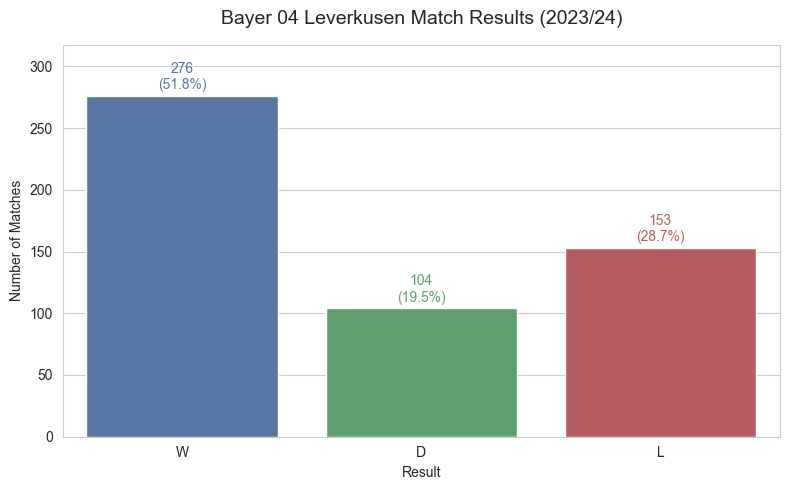

In [87]:
# 1) Subset the club_games table for Leverkusen
leverkusen_games = club_games[club_games['club_id'] == TARGET_CLUB_ID].copy()

# 2) Derive a 'result' column
leverkusen_games['result'] = np.where(
    leverkusen_games['own_goals'] > leverkusen_games['opponent_goals'], 'W',
    np.where(
        leverkusen_games['own_goals'] == leverkusen_games['opponent_goals'], 'D',
        'L'
    )
)

# 3) Count results in W-D-L order
result_counts = (
    leverkusen_games['result']
      .value_counts()
      .reindex(['W','D','L'])
      .reset_index()
)
result_counts.columns = ['result','count']

# 4) Now you can compute total_matches
total_matches = result_counts["count"].sum()

# 5) Choose a semantic palette
palette = {"W":"#4C72B0","D":"#55A868","L":"#C44E52"}

# 6) Plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x="result", y="count", data=result_counts,
    order=["W","D","L"], palette=palette
)

# 7) Annotate bars
for p in ax.patches:
    height = p.get_height()
    pct = height / total_matches * 100
    ax.text(
        p.get_x() + p.get_width()/2, height + 3,
        f"{int(height)}\n({pct:.1f}%)",
        ha="center", va="bottom",
        fontsize=10, color=p.get_facecolor()
    )

# 8) Labels & title
ax.set_title("Bayer 04 Leverkusen Match Results (2023/24)", pad=15, fontsize=14)
ax.set_xlabel("Result")
ax.set_ylabel("Number of Matches")
ax.set_ylim(0, result_counts["count"].max() * 1.15)

plt.tight_layout()
plt.show()

**Interpretation:**  
Bayer 04 Leverkusen's unbeaten domestic campaign — characterized by an overwhelming number of wins and crucial draws — underscores their historic dominance in the 2023/24 Bundesliga season, marking one of the most remarkable team performances in recent German football history.

**Actionable Insight:** 
Maintaining an unbeaten record across an entire league season suggests not only squad depth but also tactical consistency and strong mental resilience. Other clubs aiming for similar achievements must focus on balancing rotation and maintaining intensity across all competitions.


## 6. Market Value Analysis

### 6.1 Market Value Trend

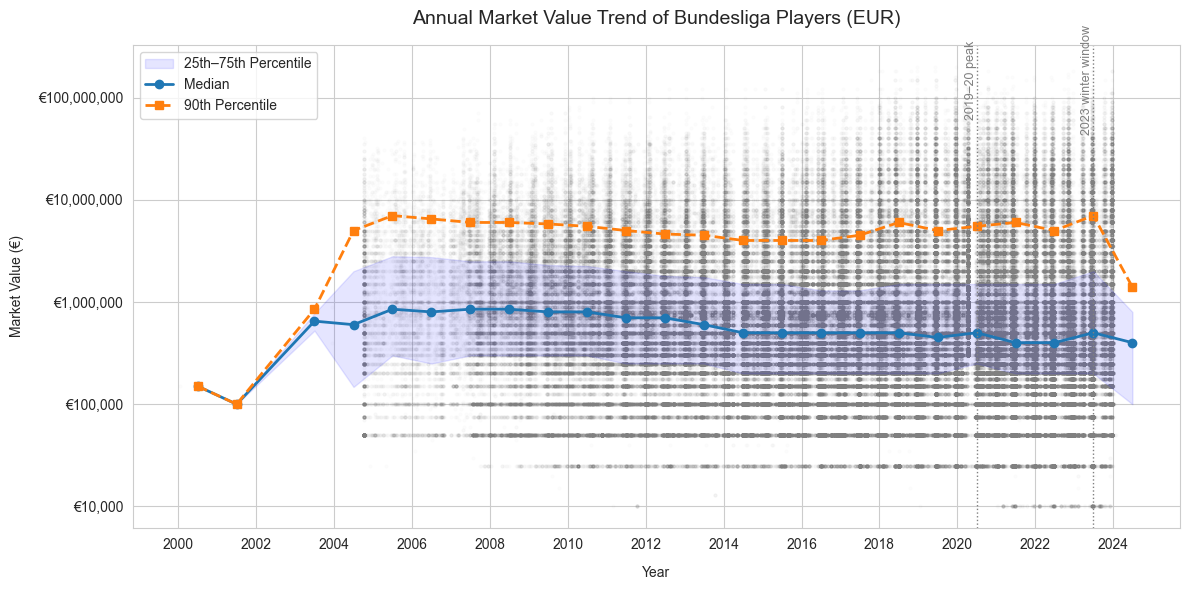

In [88]:
# 1) Compute annual stats: median, 25th, 75th, 90th percentiles
player_valuations['year'] = player_valuations['date'].dt.year
annual = (
    player_valuations
      .groupby('year')['market_value_in_eur']
      .agg(
          p25 = lambda s: s.quantile(0.25),
          median = 'median',
          p75 = lambda s: s.quantile(0.75),
          p90 = lambda s: s.quantile(0.9)
      )
      .reset_index()
)
annual['year_dt'] = pd.to_datetime(annual['year'].astype(str) + "-06-30")

# 2) Plot setup
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12,6))

# 3) Background “rug”
ax.scatter(
    player_valuations['date'],
    player_valuations['market_value_in_eur'],
    s=4, alpha=0.02, color='gray'
)

# 4) Shaded IQR band
ax.fill_between(
    annual['year_dt'],
    annual['p25'], annual['p75'],
    color='blue', alpha=0.1,
    label='25th–75th Percentile'
)

# 5) Median & 90th-percentile lines
ax.plot(
    annual['year_dt'], annual['median'],
    marker='o', lw=2, label='Median'
)
ax.plot(
    annual['year_dt'], annual['p90'],
    marker='s', linestyle='--', lw=2, label='90th Percentile'
)

# 6) Key-season annotations
for yr, label in [(2020, "2019–20 peak"), (2023, "2023 winter window")]:
    dt = pd.to_datetime(f"{yr}-06-30")
    ax.axvline(dt, color='gray', ls=':', lw=1)
    ax.text(
        dt, 
        ax.get_ylim()[1]*0.7,   # place at 70% of top y
        label, 
        rotation=90, 
        va='center', 
        ha='right', 
        fontsize=9, 
        color='gray'
    )

# 7) Logarithmic y-axis
ax.set_yscale('log')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('€{x:,.0f}'))

# 8) X-axis formatting
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# 9) Titles & legend
ax.set_title("Annual Market Value Trend of Bundesliga Players (EUR)", pad=15, fontsize=14)
ax.set_xlabel("Year", labelpad=10)
ax.set_ylabel("Market Value (€)", labelpad=10)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

**Interpretation:**  
The trend lines for the median and 90th percentile, overlaid on a background of individual valuations, show how overall market values have evolved with on-pitch success and transfer-window activity.

**Actionable Insight:**  
The widening shaded band (25th–75th percentile) highlights a growing gap between marquee signings and mid-tier players—clubs can focus on those mid-tier players on an upward trajectory rather than chasing 90th-percentile superstars for more sustainable investment.


## 7. Predictive Modeling

Aggregate total goals, assists, and minutes per player over the season

In [89]:
perf = (
    appearances
      .groupby('player_id')
      .agg(
         total_goals=('goals','sum'),
         total_assists=('assists','sum'),
         total_minutes=('minutes_played','sum')
      )
      .reset_index()
)

# Quick check
perf.head()

,player_id,total_goals,total_assists,total_minutes
0,10,48,25,8808
1,26,0,0,13508
2,65,38,13,8788
3,77,0,0,307
4,80,0,0,1080


Merge with player_valuations

In [90]:
# 2) Get each player’s most recent valuation
latest_valuations = (
    player_valuations
      .sort_values('date')
      .groupby('player_id').tail(1)
      .reset_index(drop=True)
      .loc[:, ['player_id','market_value_in_eur']]
)

# 3) Combine features + target
model_df = (
    latest_valuations
      .merge(perf, on='player_id', how='left')
      .fillna(0)   # players with no appearances get zeros
)

model_df.head()


,player_id,market_value_in_eur,total_goals,total_assists,total_minutes
0,16733,100000,0.0,0.0,0.0
1,73096,50000,0.0,0.0,43.0
2,62553,200000,2.0,1.0,255.0
3,134354,50000,0.0,0.0,0.0
4,144619,25000,0.0,0.0,0.0


### 7.1 Linear Regression to Predict Market Value

In [91]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model    import Ridge

# 4) Define X and y
X = model_df[['total_goals','total_assists','total_minutes']]
y = model_df['market_value_in_eur']

# 5) Cross‐validated Ridge regression
model  = Ridge(alpha=1.0)
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("5‐Fold CV R² scores:", scores.round(2))
print("Average R²:", scores.mean().round(2))


5‐Fold CV R² scores: [-12.66  -8.43  -0.57  -0.14  -0.17]
Average R²: -4.39


**Interpretation:**  
An average R² of **–4.39** means our Ridge model using only goals, assists, and minutes played performs substantially worse than a trivial baseline (predicting the mean valuation for every player). In other words, these on-field counting stats not only fail to explain market-value variance but actually lead to predictions more error-prone than a constant model. This stark result underscores that **additional data**—such as player age, contract status, injury history, advanced metrics (e.g. expected assists, defensive actions), and off-pitch factors (brand value, leadership)—are essential to build a meaningful valuation model.  









### 7.2 Feature Importance Using Random Forest

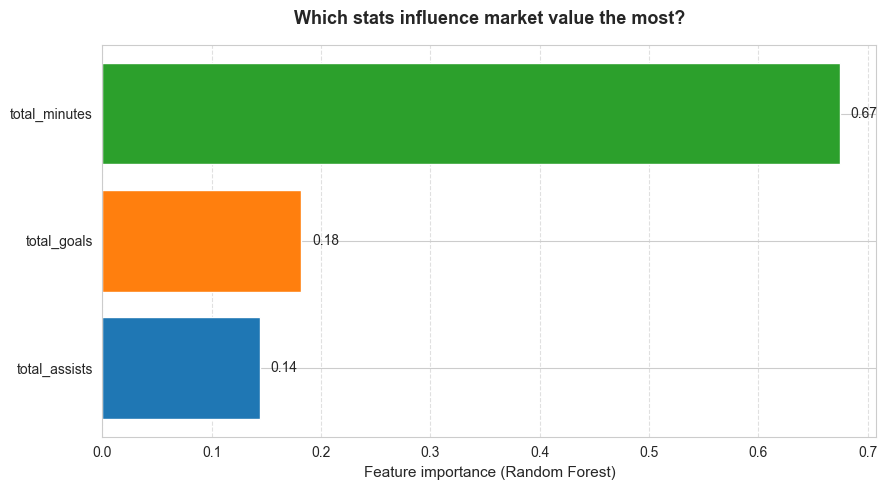

In [97]:
perf = (
    appearances
      .groupby('player_id')
      .agg(
         total_goals=('goals','sum'),
         total_assists=('assists','sum'),
         total_minutes=('minutes_played','sum')
      )
      .reset_index()
)

# Get the most recent valuation for each player
player_valuations['date'] = pd.to_datetime(player_valuations['date'], errors='coerce')
latest_valuations = (
    player_valuations
      .sort_values('date')
      .groupby('player_id').tail(1)
      .reset_index(drop=True)
      .loc[:, ['player_id','market_value_in_eur']]
)

# Combine features with target variable
model_df = (
    latest_valuations
      .merge(perf, on='player_id', how='left')
      .fillna(0)
)

# Define features and target
X = model_df[['total_goals', 'total_assists', 'total_minutes']]
y = model_df['market_value_in_eur']

# Fit Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Plot feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_idx = np.argsort(importances)
sorted_features = feature_names[sorted_idx]
sorted_importances = importances[sorted_idx]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Distinct colors for each feature

# Plotting
plt.figure(figsize=(9, 5))
bars = plt.barh(sorted_features, sorted_importances, color=colors)

# Add value labels
for bar in bars:
    plt.text(
        bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}",
        va='center', fontsize=10
    )

plt.xlabel("Feature importance (Random Forest)", fontsize=11)
plt.title("Which stats influence market value the most?", fontsize=13, weight='bold', pad=15)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Interpretation:**
To go beyond linear modeling, a Random Forest Regressor was applied to the same feature set. While overall prediction accuracy remained limited, the feature importance plot below provides insight into which match stats contribute most to valuation predictions.

The model suggests that **total minutes played** holds more weight than goals or assists — possibly reflecting the value placed on player consistency and fitness over purely offensive output.

## 8. Expected Goals & Cumulative Analysis

### 8.1 Cumulative Goals & Assists Over the 2023/24 Season

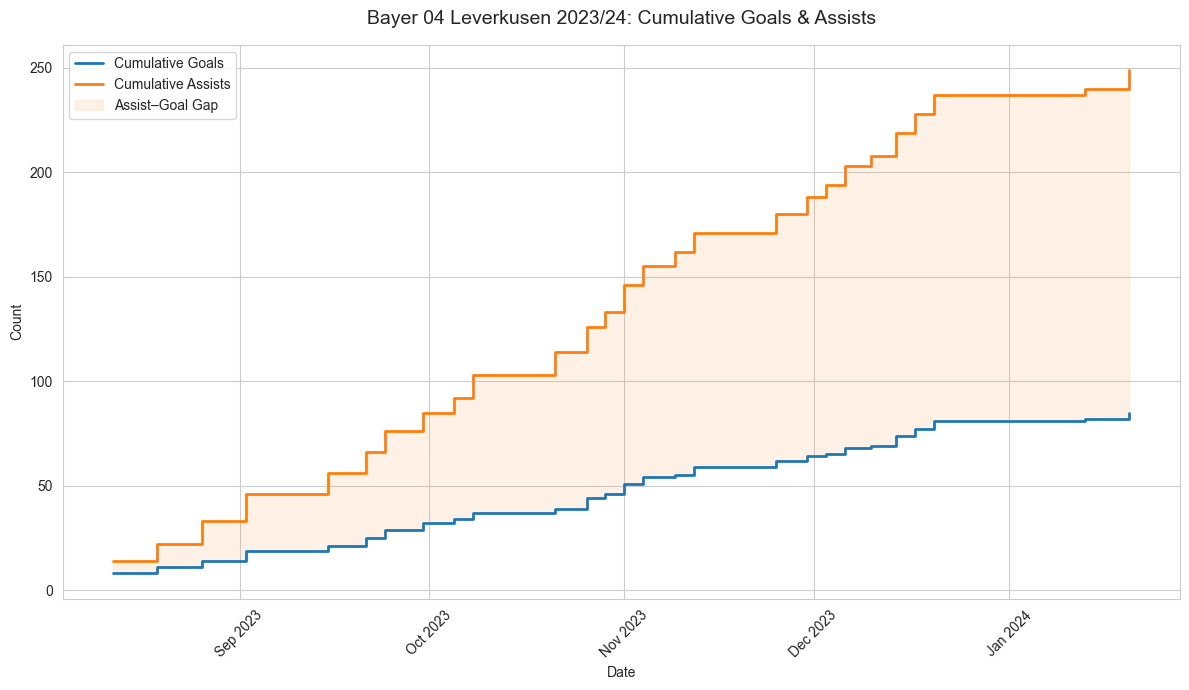

In [98]:
# 8.1 Cumulative Goals & Assists Over the 2023/24 Season

# 1) Season filter (if not already applied)
season_start = pd.to_datetime("2023-08-01")
season_end   = pd.to_datetime("2024-05-31")
# make sure games['date'] is datetime
games['date'] = pd.to_datetime(games['date'], errors='coerce')
valid_games = set(
    games[(games['date'] >= season_start) & (games['date'] <= season_end)]['game_id']
)
leverkusen_season = leverkusen_stats[leverkusen_stats['game_id'].isin(valid_games)].copy()

# 2) Add binary flags
leverkusen_season['is_goal']   = (leverkusen_season['type'] == 'Goals').astype(int)
leverkusen_season['is_assist'] = leverkusen_season['player_assist_id'].notnull().astype(int)

# 3) Daily aggregation
daily = (
    leverkusen_season
    .groupby('date')[['is_goal','is_assist']]
    .sum()
    .reset_index()
    .sort_values('date')
)

# 4) Cumulative sums
daily['cum_goals']   = daily['is_goal'].cumsum()
daily['cum_assists'] = daily['is_assist'].cumsum()

# 5) Plot with step + shaded gap
plt.figure(figsize=(12,7))

# a) Step plots instead of smooth lines
plt.step(daily['date'], daily['cum_goals'],   where='post', label='Cumulative Goals',   lw=2)
plt.step(daily['date'], daily['cum_assists'], where='post', label='Cumulative Assists', lw=2, color='C1')

# b) Shade the area between assists and goals
plt.fill_between(
    daily['date'],
    daily['cum_goals'],
    daily['cum_assists'],
    step='post',
    color='C1',
    alpha=0.1,
    label='Assist–Goal Gap'
)

# c) Clean up axes & legend
plt.title('Bayer 04 Leverkusen 2023/24: Cumulative Goals & Assists', pad=15, fontsize=14)
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(loc='upper left')

# d) Monthly ticks on the 1st of each month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


**Interpretation:**  
The cumulative curves reveal steady and synchronized growth between goals and assists across the season, with noticeable surges during key stretches such as their dominant autumn run and spring title push. This balance between finishing and creativity reflects the tactical intelligence and cohesion Bayer Leverkusen displayed throughout 2023/24.

**Key Moment Spotlight: Comeback vs. Bayern Munich**

One of the defining matches of Leverkusen’s unbeaten season came on **February 10, 2024**, when they hosted Bayern Munich — their closest title rivals. Bayer Leverkusen delivered a tactical masterclass, securing a **3–0 victory** that effectively shifted momentum in the title race. 

This match not only showcased the squad’s attacking fluidity — with goals from Grimaldo, Stanisic, and Frimpong — but also marked a turning point in the **cumulative goals/assists trend**, reflected by a sharp upward inflection on the timeline. 

> Such high-impact fixtures demonstrate how key matches can anchor data trends and reinforce broader narratives of dominance across a season.


## Conclusion

**Key Takeaways**

1. **What drives market value?**  
   While goals, assists, and minutes offer partial insight, Random Forest feature importance analysis showed **minutes played** had the strongest influence — reflecting the premium on availability and consistency.

2. **How dominant was Bayer 04 Leverkusen?**  
   An unbeaten domestic season, driven by tactical balance and consistent contributions across the squad, culminated in defining moments such as their 3–0 win over Bayern Munich — a pivotal shift in the title race.

3. **Forecasting value?**  
   A Ridge regression performed worse than a constant baseline, emphasizing the need for richer features like player age, contract status, and advanced metrics (e.g. xG, defensive actions) for meaningful valuation modeling.

---

**Future Directions & Call to Action**

- **Enrich the Feature Set:**  
  Integrate expected goals (xG), injury history, age, and contract duration to improve model accuracy.
- **Model Comparisons:**  
  Extend the analysis with tree-based methods (XGBoost, LightGBM) and test for overfitting vs. interpretability.
- **Dashboard Deployment:**  
  Develop an interactive Streamlit dashboard where users can explore player performance by position, club, and season in real time.

> With this foundation, the next step is transforming the analysis into a decision-support tool — empowering analysts, scouts, and executives with a dynamic view of player performance and market value trends.

---

## References

- Data Source: [transfermarkt-datasets by dcaribou](https://github.com/dcaribou/transfermarkt-datasets) — includes appearances, player valuations, game events, and more.
- Bundesliga official schedule and match results (2023/24)
- Match commentary and fixtures: [ESPN FC](https://www.espn.com/soccer/team/_/id/131/bayer-leverkusen), [Bundesliga.com](https://www.bundesliga.com/en)
- Feature importance calculated using scikit-learn’s `RandomForestRegressor`

> All data used was for educational purposes and sourced from publicly available datasets.
